# Conclude Session of Recommondation System

Progress so far:
1. Data Cleaning and Modification
2. Clustering on whole data
3. Data Segmentation based on consistency
4. Deep learning mode on consistent groups

In this page, I'm going to construct a re-cap of my previous work with a clean and clear version. Then made some modification on clustering and data segmentation for the sake of next step's preparation.

The idea includes:
1. Conclude M18 and 19
2. Modify the way of data segmentation (v1-v4)
3. Other algorithms of clustering
4. Confirm how the recommendation system perform
5. Make sure the system is good for new data inputs

In [ ]:
# Read Current Data (M19's way of defining v1, v2, v3
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
svd_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\df_svd.csv"
# v1_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v1.csv"
# v2_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v2.csv"
# v3_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v3.csv"

df = pd.read_csv(full_dataset, encoding="Windows-1252")
# df_v1 = pd.read_csv(v1_data, encoding="Windows-1252")
# df_v2 = pd.read_csv(v2_data, encoding="Windows-1252")
# df_v3 = pd.read_csv(v3_data, encoding="Windows-1252")
df_svd = pd.read_csv(svd_data, encoding="Windows-1252")

## Data Loading and Cleaning

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

In [2]:
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Define trash columns
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']

df = drop_high_nan_columns(df) 
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # age group preparation (modify to int)
df = days_cal_v2(df,'last_visit','first_visit','visit_period')

# # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"
df = one_hot_encode_procedure_and_treatment(df)
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\1647155174.py:2: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will 

- Create a complete dataset to reflect each patient_id's treatment pattern (aassuming all meta columns stand the same for each unique patient id)
- Applied Truncated SVD which is the best for sparse binary data of large sparse matrices.

Note: `final_df` is generated from whole dataset; `df_svd` is based on it. Replace it with any new version of dataset if needed

In [4]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

df_next = df.copy()
# Define Constant columns
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']

# Select relevant columns
base_cols = ['patient_id', 'procedure_age']
procedure_cols = [col for col in df_next.columns if col.startswith('procedure_code_y_') or col.startswith('treatment_category_')]
df_subset = df_next[base_cols + procedure_cols].copy()
df_subset['procedure_age'] = df_subset['procedure_age'].astype(int) # procedure_age to int

# Melt one-hot to long format
df_long = df_subset.melt(
    id_vars=['patient_id', 'procedure_age'],
    value_vars=procedure_cols,
    var_name='procedure_code',
    value_name='occurred'
)

# Keep only rows where procedure occurred
df_long = df_long[df_long['occurred'] == 1]

# Create combined feature name
df_long['feature'] = df_long['procedure_code'] + '_age' + df_long['procedure_age'].astype(str)

# Pivot to wide format
final_df = df_long.groupby(['patient_id', 'feature']).size().unstack(fill_value=0)
final_df = final_df.reset_index()

# Get metadata (take first row per patient) # may need further fixing if the information for such patient changed over times
patient_meta = df_next[meta_cols].groupby('patient_id').first().reset_index()
final_df = pd.merge(patient_meta, final_df, on='patient_id', how='left')

# columns to exclude from SVD
non_binary_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE','procedure_age', 'visit_period']
meta_df = final_df[non_binary_cols].copy()
binary_df = final_df.drop(columns=non_binary_cols)

# Apply TruncatedSVD on binary columns
X_sparse = csr_matrix(binary_df.values)
svd = TruncatedSVD(n_components=100, random_state=823)
X_svd = svd.fit_transform(X_sparse)
svd_features = pd.DataFrame(X_svd, columns=[f"SVD_{i+1}" for i in range(X_svd.shape[1])])
df_svd = pd.concat([meta_df.reset_index(drop=True), svd_features], axis=1)

In [14]:
df_svd.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\df_svd.csv', index=False)

- Dataframe for 17 age groups, start from 5-10, up to 85-90
- Dataframe for each age groups

Note: Change `df` to any version of `dataset` if needed

In [ ]:
# Key functions to separate the data in different year windows
import os

# 5 year window
def age_to_group(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        lower = (age // 5) * 5
        upper = lower + 5
        if lower > upper:
            return "invalid"
        return f"{lower}-{upper}"
    except:
        return "invalid"

df['age_group'] = df['procedure_age'].apply(age_to_group)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M18\Split dataframe 5 year"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df.groupby('age_group'):
    filename = f"{output_dir}/age_group_{group_name}.csv"
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")


# 1 year window
def age_to_group(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        return f"{age}"
    except:
        return "invalid"

df['age_group'] = df['procedure_age'].apply(age_to_group)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M18\Split dataframe yearly"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

### Data Segmentation

#### Divide patient-level treatment dataset into three groups (V1, V2, V3, v4) based on the continuity and duration of their visit history
Definitions:
- First Visit Date: Start of treatment history
- Last Visit Date: End of treatment history
- Procedure Data: The date which procedure occurred
- Max Gap: Largest time gap between consecutive visits
- Duration: Total time span = Last Visit Date - First Visit Date

V1 (Consistent long history): Max gap between visits is less or equal to 2 years, with total treatment of more or equal to 3 years.   
V2 (Consistent Short history): Max gap between visits is less than 2 years, with total treatment of less than 3 years.  
V3 (Inconsistent but Long History): Max gap is 2 years or more; Total duration is 7 years or more.    
V4 (Inconsistent and Short History): Everything else.  

In [ ]:
## Old classification stream
# df_next = df.copy() # for next step use
# def classify_patient(group):
#     procedure_dates = group.sort_values('procedure_date')['procedure_date']
    
#     # Visit span in years
#     span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

#     # Maximum time gap between consecutive visits
#     gaps = procedure_dates.diff().dropna().dt.days / 365.0
#     max_gap = gaps.max() if not gaps.empty else 0

#     # Classification
#     if span_years >= 1 and max_gap <= 2:
#         return 'V1'
#     elif span_years >= 7:
#         return 'V2'
#     else:
#         return 'V3'

# # Apply the classification
# patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
# patient_versions.columns = ['patient_id', 'version']

# # Merge version info back to full dataset (Treatment Based)
# df_next = df_next.merge(patient_versions, on='patient_id')

C:\Users\frank\AppData\Local\Temp\ipykernel_9708\163003166.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()


In [ ]:
# New classifiaction stream
f_next = df.copy()
def classify_patient(group):
    procedure_dates = group.sort_values('procedure_date')['procedure_date']

    # Calculate total treatment span in years
    span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

    # Calculate max gap between consecutive visits in years
    gaps = procedure_dates.diff().dropna().dt.days / 365.0
    max_gap = gaps.max() if not gaps.empty else 0

    # Classification rules
    if max_gap <= 2:
        if span_years >= 3:
            return 'V1'  # Consistent long history
        else:
            return 'V2'  # Consistent short history
    elif max_gap > 2 and span_years >= 7:
        return 'V3'  # Inconsistent but long history
    else:
        return 'V4'  # Inconsistent and short history (everything else)

# Apply the classification to each patient group
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']

# Merge version info back into the main dataset
df_next = df_next.merge(patient_versions, on='patient_id')

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\2808816821.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()


In [252]:
df_next['version'].value_counts()

version
V3    180491
V1    103641
V2     34236
V4     14147
Name: count, dtype: int64

In [253]:
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']
df_v4 = df_next[df_next['version'] == 'V4']

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\3372012186.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = df_next.groupby(['version', 'age_group']).size().unstack().fillna(0)


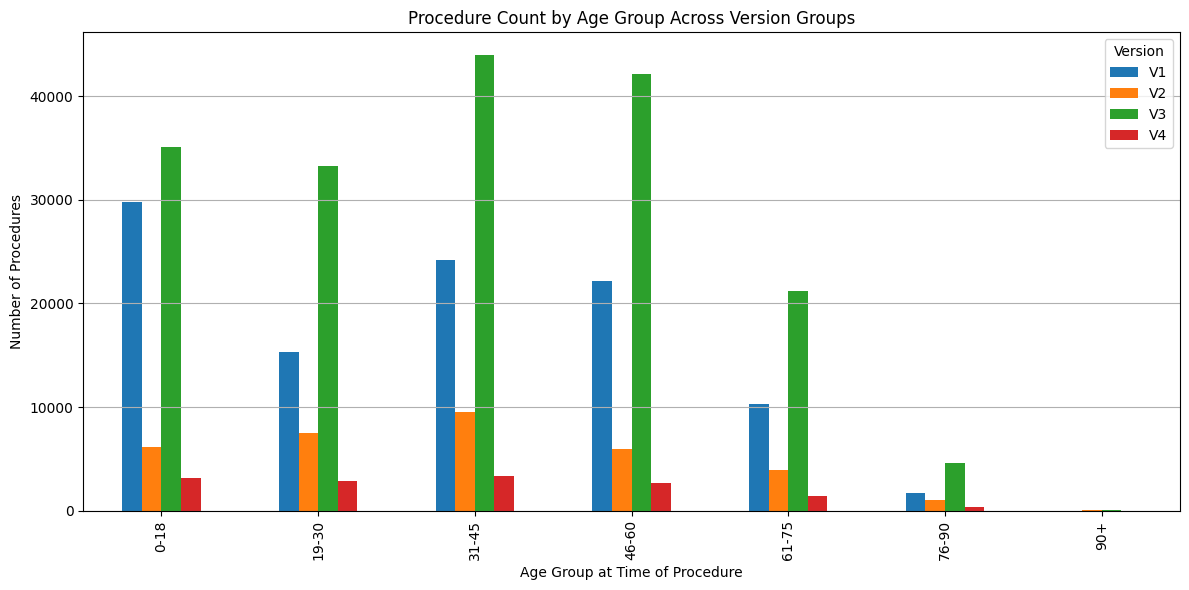

In [ ]:
# Calculate age at time of each procedure
df_next['age_at_procedure'] = (df_next['procedure_date'] - df_next['birth_date']).dt.days // 365

# Bucket into age groups
df_next['age_group'] = pd.cut(
    df_next['age_at_procedure'],
    bins=[0, 18, 30, 45, 60, 75, 90, 120],
    labels=['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '90+'])

# Count procedures per age group and version
age_distribution = df_next.groupby(['version', 'age_group']).size().unstack().fillna(0)

# Plot
age_distribution.T.plot(kind='bar', figsize=(12, 6))
plt.title("Procedure Count by Age Group Across Version Groups")
plt.xlabel("Age Group at Time of Procedure")
plt.ylabel("Number of Procedures")
plt.grid(axis='y')
plt.legend(title='Version')
plt.tight_layout()
plt.show()

- V3 (Inconsistent, Long History) dominates across nearly all age groups, suggests many patients have long timelines but irregular visit patterns.
- V1 (Consistent, Long History) is the second largest group and it has strongest presence in 0–18 and 31–60 which reflects patients with reliable visit patterns and long history.
- V2, V4 may not be relevant data as they don't add value.



In [248]:
# 1 year window
def age_to_group_yearly(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        return f"{age}"
    except:
        return "invalid"

In [251]:
df_v1

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version,age_at_procedure,age_group
9,1,544.16,0,2007-07-10,6239,1968-07-15,3,0,1998-04-14,2022-07-13,...,False,False,False,False,False,False,False,V1,39,31-45
14,2,30.00,0,2007-07-10,5913,1935-10-26,2,0,1997-08-12,2015-06-22,...,False,False,False,False,False,False,False,V1,71,61-75
18,2,99.81,0,2001-10-22,5913,1935-10-26,2,0,1997-08-12,2015-06-22,...,False,False,False,False,False,False,False,V1,66,61-75
21,1,59.11,0,2007-07-10,9456,2003-10-15,5,0,2007-07-10,2024-10-19,...,False,False,False,False,False,False,False,V1,3,0-18
22,4,96.26,0,2007-07-09,5492,1960-08-11,0,0,1996-11-12,2024-07-18,...,False,False,False,False,False,False,False,V1,46,46-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332504,4,33.46,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,V1,46,46-60
332505,0,96.81,0,2000-09-30,8378,1999-07-27,0,0,2003-09-23,2009-12-08,...,False,False,False,False,False,False,False,V1,1,0-18
332506,0,96.81,0,2000-09-30,1165,1941-07-08,1,0,1989-07-25,2024-12-19,...,False,False,False,False,False,False,False,V1,59,46-60
332509,4,96.26,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,V1,46,46-60


In [257]:
df_v1['age_group'] = df_v1['procedure_age'].apply(age_to_group_yearly)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df_v1.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_v1_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\1704885489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1['age_group'] = df_v1['procedure_age'].apply(age_to_group_yearly)


Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_0.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_1.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_10.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_11.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_12.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_13.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_14.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_16.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_17.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Proj

In [258]:
df_v3['age_group'] = df_v3['procedure_age'].apply(age_to_group_yearly)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df_v3.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_v3_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\2122947709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3['age_group'] = df_v3['procedure_age'].apply(age_to_group_yearly)


Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_0.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_1.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_10.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_11.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_12.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_13.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_14.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_16.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_17.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Proj

End up with 2 key datasets:   
Dataset 1: 2 version of (v1 and v3) separated datasets which are split by age groups. (5-year or yearly)  
Dataset 2: One complete dataset to contain all treatment history of each patient_id throughout all of their procedure time. (SVD); This is a compact representation of each patient’s historical treatment behavior.  


## Unsupervised Learning Recommondation Model

### Clustering data using `df_svd`

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Kmeans
def cluster_patients_kmeans(df_svd, n_clusters=6):
    # Select only the SVD columns
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Add cluster labels to the DataFrame
    df_svd['cluster'] = cluster_labels

    return df_svd, kmeans, scaler


# AgglomerativeClustering
def cluster_patients_agglomerative(df_svd, n_clusters=6):
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    agglo = AgglomerativeClustering(n_clusters=n_clusters)

    df_svd['cluster'] = agglo.fit_predict(X_scaled)

    return df_svd, agglo, scaler

# GMM
def cluster_patients_gmm(df_svd, n_clusters=6):
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    df_svd['cluster'] = gmm.fit_predict(X_scaled)

    return df_svd, gmm, scaler

- KMeans baseline  
Baseline clustering model fast and interpretable.  

- Gaussian Mixture Model (GMM) for soft, overlapping patterns  
Patient histories may overlap.  
Can model elliptical clusters, good for reduced features (like SVD).  
Helps find blurry boundaries.  

- Agglomerative Clustering for interpretable structure  
Good for visualizing treatment relationships or creating treatment hierarchies.  
Reveals hierarchical structure — can be useful if patient groups nest within others.  
Good for understanding group similarity.  

Metrics to Evaluate k:  
- Inertia (Elbow Method): How spread out the points are in their clusters
- Silhouette Score: How similar a point is to its own cluster to others

In [ ]:
from sklearn.metrics import silhouette_score

# Kmeans
def grid_search_kmeans(df_svd, svd_prefix='SVD_', k_min=4, k_max=10):
    """
    Performs a grid search over k for KMeans and plots inertia and silhouette scores.
    """
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = df_svd[svd_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    k_values = list(range(k_min, k_max + 1))
    inertias = []
    silhouettes = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertias, marker='o')
    plt.title('Elbow Method: Inertia vs. k')
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouettes, marker='o')
    plt.title('Silhouette Score vs. k')
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return k_values, inertias, silhouettes

    from sklearn.mixture import GaussianMixture

# GMM
def grid_search_gmm(df_svd, svd_prefix='SVD_', k_range=range(4, 10)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = df_svd[svd_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    scores = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X_scaled)
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1
        scores.append(score)
        print(f"GMM - k={k}, Silhouette Score: {score:.4f}")

    best_k = k_range[scores.index(max(scores))]
    best_model = GaussianMixture(n_components=best_k, random_state=42).fit(X_scaled)
    return best_model, best_k, scores

from sklearn.cluster import AgglomerativeClustering

# Agglomerative
def grid_search_agglomerative(df_svd, svd_prefix='SVD_', k_range=range(4, 10)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = df_svd[svd_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    scores = []
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(X_scaled)
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1
        scores.append(score)
        print(f"Agglomerative - k={k}, Silhouette Score: {score:.4f}")

    best_k = k_range[scores.index(max(scores))]
    best_model = AgglomerativeClustering(n_clusters=best_k).fit(X_scaled)
    return best_model, best_k, scores


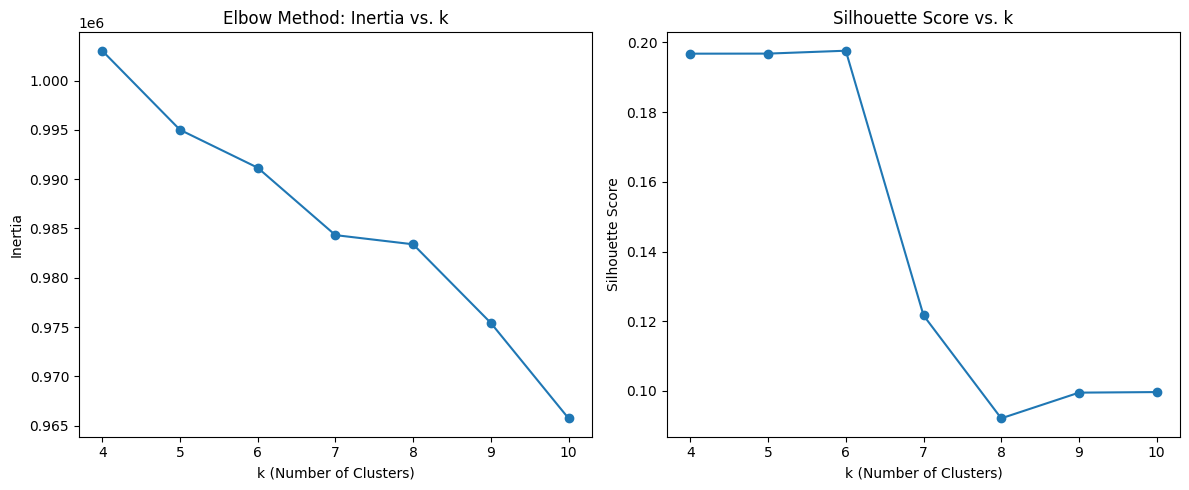

GMM - k=4, Silhouette Score: 0.0163
GMM - k=5, Silhouette Score: -0.0154
GMM - k=6, Silhouette Score: -0.0143
GMM - k=7, Silhouette Score: -0.0461
GMM - k=8, Silhouette Score: -0.0849
GMM - k=9, Silhouette Score: -0.0769
Agglomerative - k=4, Silhouette Score: 0.7889
Agglomerative - k=5, Silhouette Score: 0.7890
Agglomerative - k=6, Silhouette Score: 0.0653
Agglomerative - k=7, Silhouette Score: 0.0662
Agglomerative - k=8, Silhouette Score: 0.0666
Agglomerative - k=9, Silhouette Score: 0.0682


In [ ]:
grid_search_kmeans(df_svd)
best_gmm, best_k_gmm, gmm_scores = grid_search_gmm(df_svd)
best_agg, best_k_agg, agg_scores = grid_search_agglomerative(df_svd)

Kmeans: k = 6  
GMM: k = 4  
Agglomerative: k = 5


In [187]:
df_sv_kmeans, kmeans, scaler = cluster_patients_kmeans(df_svd, n_clusters=6)
cluster_map_kmeans = df_sv_kmeans[['patient_id', 'cluster']]
cluster_map_kmeans

,patient_id,cluster
0,1,3
1,2,4
2,3,3
3,4,3
4,5,3
...,...,...
10253,13579,3
10254,13580,3
10255,13583,3
10256,13584,3


In [191]:
df_sv_gmm, gmm, scaler_gmm = cluster_patients_gmm(df_svd, n_clusters=4)
cluster_map_gmm = df_sv_gmm[['patient_id', 'cluster']]
cluster_map_gmm

,patient_id,cluster
0,1,3
1,2,3
2,3,0
3,4,3
4,5,0
...,...,...
10253,13579,0
10254,13580,0
10255,13583,0
10256,13584,0


In [235]:
df_sv_agg, agg, scaler_agg = cluster_patients_agglomerative(df_svd, n_clusters=5)
cluster_map_agg = df_sv_agg[['patient_id', 'cluster']]
cluster_map_agg

,patient_id,cluster
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
10253,13579,0
10254,13580,0
10255,13583,0
10256,13584,0


### Add the cluster label from df_svd into each of 99 age-group files, so every patient in each file knows their cluster.

In [260]:
import os
def annotate_age_group_files(folder_path, output_path, cluster_map):
    os.makedirs(output_path, exist_ok=True)

    for file in sorted(os.listdir(folder_path)):

        # age = int(file.replace("age_group_", "").replace(".csv", ""))
        age = int(file.split("_")[-1].replace(".csv", ""))
        file_path = os.path.join(folder_path, file)

        # read CSV
        df = pd.read_csv(file_path)

        # Merge with cluster label
        df = df.merge(cluster_map, on='patient_id', how='left')

        # save as CSV
        output_file = os.path.join(output_path, f"age_group_{age}_clustered.csv")
        df.to_csv(output_file, index=False)

    print("All files updated with cluster info.")

In [261]:
# folder_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\Split dataframe yearly v1"
folder_path_v1 = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1"
folder_path_v3 = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3"
output_path_k = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M20\cluster_kmeans"
output_path_gmm = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M20\cluster_gmm"
output_path_agg = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M20\cluster_agg"

annotate_age_group_files(folder_path_v1, output_path_k, cluster_map_kmeans)
annotate_age_group_files(folder_path_v1, output_path_gmm, cluster_map_gmm)
annotate_age_group_files(folder_path_v1, output_path_agg, cluster_map_agg)

annotate_age_group_files(folder_path_v3, output_path_k, cluster_map_kmeans)
annotate_age_group_files(folder_path_v3, output_path_gmm, cluster_map_gmm)
annotate_age_group_files(folder_path_v3, output_path_agg, cluster_map_agg)

All files updated with cluster info.
All files updated with cluster info.
All files updated with cluster info.
All files updated with cluster info.
All files updated with cluster info.
All files updated with cluster info.


### Build Trajectory Dictionary

In [193]:
from collections import defaultdict

def build_trajectory_dict(clustered_folder, procedure_prefix="procedure_code_y_"):
    """
    Create a nested dictionary mapping cluster_id to age to list of top 5 procedure codes.
    """
    # Initialize Nested Dictionary
    trajectory_dict = defaultdict(dict)

    # Goes through each .csv file in the folder
    for file in sorted(os.listdir(clustered_folder)):
        # Extract age from filename
        try:
            age = int(file.replace("age_group_", "").replace("_clustered.csv", "").replace(".csv", ""))
        except ValueError:
            continue

        df = pd.read_csv(os.path.join(clustered_folder, file))
        procedure_cols = [col for col in df.columns if col.startswith(procedure_prefix)]

        for cluster_id in df['cluster'].dropna().unique():
            sub_df = df[df['cluster'] == cluster_id]
            if sub_df.empty:
                continue

            proc_counts = sub_df[procedure_cols].sum().sort_values(ascending=False)
            top_procs = [col.replace(procedure_prefix, "") for col in proc_counts.head(5).index]
            trajectory_dict[int(cluster_id)][age] = top_procs

    return trajectory_dict


In [194]:
trajectory_dict_kmeans = build_trajectory_dict(output_path_k)
trajectory_dict_gmm = build_trajectory_dict(output_path_gmm)
trajectory_dict_agg = build_trajectory_dict(output_path_agg)

Goal: trajectory_dict[cluster_id][age] = ["procedure_code1", "procedure_code2", ...]

In [216]:
trajectory_dict_gmm[2]

{16: ['71101', '72100', '11303', '1011', '51722'],
 18: ['71201', '2142', '51722', '49211', '49219'],
 20: ['12101', '11103', '1103', '2601', '49211'],
 21: ['43413', '2142', '1203', '51722', '49211'],
 22: ['2144', '11113', '1203', '12101', '51922'],
 23: ['11117', '11113', '51711', '43711', '49101'],
 24: ['12101', '11114', '23322', '23321', '1204'],
 25: ['2144', '11114', '1204', '51711', '49101'],
 27: ['2144', '11113', '1204', '12101', '51922'],
 29: ['1202', '2601', '23111', '23311', '2142'],
 30: ['11107', '1204', '2144', '2111', '11112'],
 31: ['11113', '11112', '1204', '1011', '51711'],
 32: ['99111', '14611', '97121', '11113', '11101'],
 33: ['1202', '2114', '1011', '49211', '49219'],
 34: ['11113', '11112', '11101', '1011', '51301'],
 35: ['2114', '11107', '1011', '51711', '49101'],
 36: ['2114', '11113', '11101', '1011', '51301'],
 38: ['1202', '11114', '23323', '12101', '2114'],
 39: ['11117', '11113', '12101', '1202', '2114'],
 40: ['11117', '12101', '11107', '51711', '49

In [237]:
trajectory_dict_gmm[2][16]

['71101', '72100', '11303', '1011', '51722']

In [214]:
trajectory_dict_agg[4]

{65: ['2601', '12101', '67211', '11107', '23323'],
 66: ['1202', '1205', '23321', '2114', '51922'],
 67: ['2111', '23324', '23321', '23311', '33111'],
 68: ['11113', '1202', '11117', '23314', '2114'],
 69: ['1202', '2144', '23312', '11113', '23113'],
 70: ['2144', '1202', '49101', '49211', '49219'],
 71: ['1202', '2142', '2112', '51722', '49101'],
 72: ['12111', '1011', '43612', '49101', '49211'],
 73: ['2144', '11113', '12111', '11101', '51301'],
 74: ['2111', '2101', '23324', '1205', '43711'],
 75: ['23311', '43413', '49101', '49211', '49219'],
 76: ['99555', '23114', '99111', '27205', '79932']}

### Weighted Recommendation (Similarity Scoring)

In [228]:
def calculate_similarity(row, target_row, feature_weights):
    score = 0
    for feature, weight in feature_weights.items():
        if feature in row and feature in target_row:
            score += weight * (row[feature] == target_row[feature])
    return score

In [229]:
def recommend_weighted_procedures(
    patient_id,
    current_age,
    df_svd,
    trajectory_dict,
    clustered_folder,
    feature_weights=None,
    procedure_prefix="procedure_code_y_",
    top_n=5):
    
    if feature_weights is None:
        feature_weights = {"city": 1.0, "state": 0.5, "treatment_category": 1.5}

    if patient_id not in df_svd['patient_id'].values:
        return []

    # Get patient metadata and cluster
    patient_info = df_svd[df_svd['patient_id'] == patient_id].iloc[0]
    cluster = patient_info['cluster']
    next_age = current_age + 1

    # Load next age file
    filename = f"age_group_{next_age}_clustered.csv"
    file_path = os.path.join(clustered_folder, filename)

    if not os.path.exists(file_path):
        return []

    df_next = pd.read_csv(file_path)

    # Filter to same cluster
    df_cluster = df_next[df_next['cluster'] == cluster]
    if df_cluster.empty:
        return []

    # Compute similarity scores
    df_cluster = df_cluster.copy()
    df_cluster["similarity"] = df_cluster.apply(lambda row: calculate_similarity(row, patient_info, feature_weights), axis=1)

    # Weight procedure code counts by similarity
    procedure_cols = [col for col in df_cluster.columns if col.startswith(procedure_prefix)]
    weighted_scores = {}

    for _, row in df_cluster.iterrows():
        for col in procedure_cols:
            weighted_scores[col] = weighted_scores.get(col, 0) + row[col] * row["similarity"]

    # Sort by score and return top N (strip prefix)
    sorted_proc = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [col.replace(procedure_prefix, "") for col, _ in sorted_proc[:top_n]]

    return recommendations


In [233]:
recommend_weighted_procedures(
    patient_id=12121,
    current_age=37,
    df_svd=df_sv_gmm,
    trajectory_dict=trajectory_dict_gmm,
    clustered_folder=output_path_gmm
)

['2144', '12111', '1103', '1202', '1204']

### Weighted based on type (consistency)

## Deep Learning (MLP/LSTM) cannot be applied by now as the data is not adqueate